In [ ]:
# @title
!pip3 install --upgrade yellowbrick

# 載入常用程式庫及定義

In [ ]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/adventures/'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

data_dir = groot_dir + 'wine quality/'
figure_dir = groot_dir + 'wine quality/'


gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath

def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]
    return s

TAIWAN_CSV = '1I5yqulrZSHPSQkxT3oqt_3uVAhPolOEP'
RED_WINE = '1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk'
TITANIC_TRAIN = '1PrxmUKRQWSlYgtMU13l1E0ob4hVJI20O'
JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
MNIST_TRAIN = '1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5'
MNIST_TRAIN_LABEL = '13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B'
MNIST_TEST = '1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg'
MNIST_TEST_LABEL = '1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z'

print('\nThis module is amied to explore wine quality csv...')

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage root points to ==>', groot_dir)
print('Wine Quality data will be stored at ==>', data_dir)
print('\nLibraries and dependenciess imported')
print_local_now()

Mounted at /content/drive

This module is amied to explore wine quality csv...

Running on linux
Python Version 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Data storage root points to ==> /content/drive/My Drive/adventures/
Wine Quality data will be stored at ==> /content/drive/My Drive/adventures/wine quality/

Libraries and dependenciess imported
Local Time: 2025-06-08 04:25:53.177193


# 熱身：sklearn load_wine

- [sklearn datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)
- [UCI Archive](https://archive.ics.uci.edu/ml/datasets/Wine)

load_xxxx() 傳回的資料是一種叫 bunch 的資料結構，裏面幾個主要欄位的意義是：

- 'features_names': 特徵名，也就是 X 各欄位的名字
- 'target_names': y 的欄位名稱
- ‘data‘： 資料的內容，也就是 X 的所有數值
- ’target‘：標籤，也就是 y 的數值


In [ ]:
from sklearn.datasets import load_wine

wdata  = load_wine()


In [ ]:
for key , value in wdata.items():
    try:
        print(key , value.shape,type(value))
    except:
        print(key, type(value))
print('--------')
print(wdata['feature_names'])
print(wdata['target_names'])

data (178, 13) <class 'numpy.ndarray'>
target (178,) <class 'numpy.ndarray'>
frame <class 'NoneType'>
target_names (3,) <class 'numpy.ndarray'>
DESCR <class 'str'>
feature_names <class 'list'>
--------
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


In [ ]:
X1 , y1 = load_wine(return_X_y=True)
X1.shape , wdata['data'].shape

wdf = pd.DataFrame(data=wdata['data'],columns=wdata['feature_names'])
wdf['target']=wdata['target']
wdf

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


### 各欄位的定義

- malic acid 蘋果酸
- ash acid 灰
- alcalinity of ash 灰的鹼性
- magnesium 鎂
- total phenols 總酚
- nonflavanoid_phenols 非類黃酮
- proanthocyanins 原花青素
- color intensity 顏色強度
- hue 色調
- proline 脯氨酸

### 欄位間的關聯

<ipython-input-6-defb24429ad2>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  wdf.hist(ax=ax)


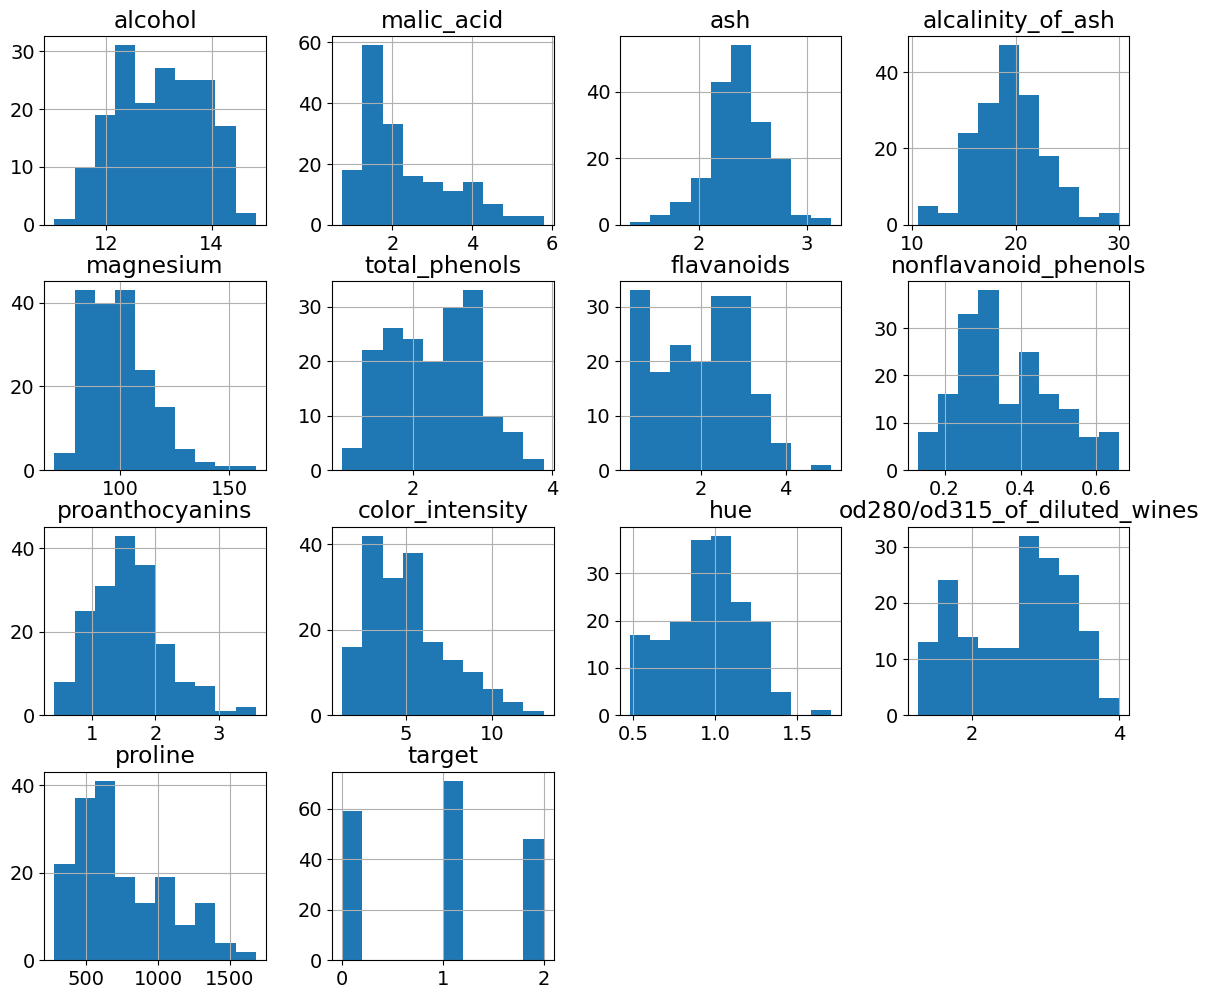

In [ ]:
fig , ax = plt.subplots(figsize=(14,12))
wdf.hist(ax=ax)
plt.show()

In [ ]:
corr = wdf.corr()
type(corr)

pandas.core.frame.DataFrame

In [ ]:
corr

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720,-0.328222
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011,0.437776
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626,-0.049643
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597,0.517859
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351,-0.209179
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115,-0.719163
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193,-0.847498
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385,0.489109
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417,-0.499130
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100,0.265668


<Axes: >

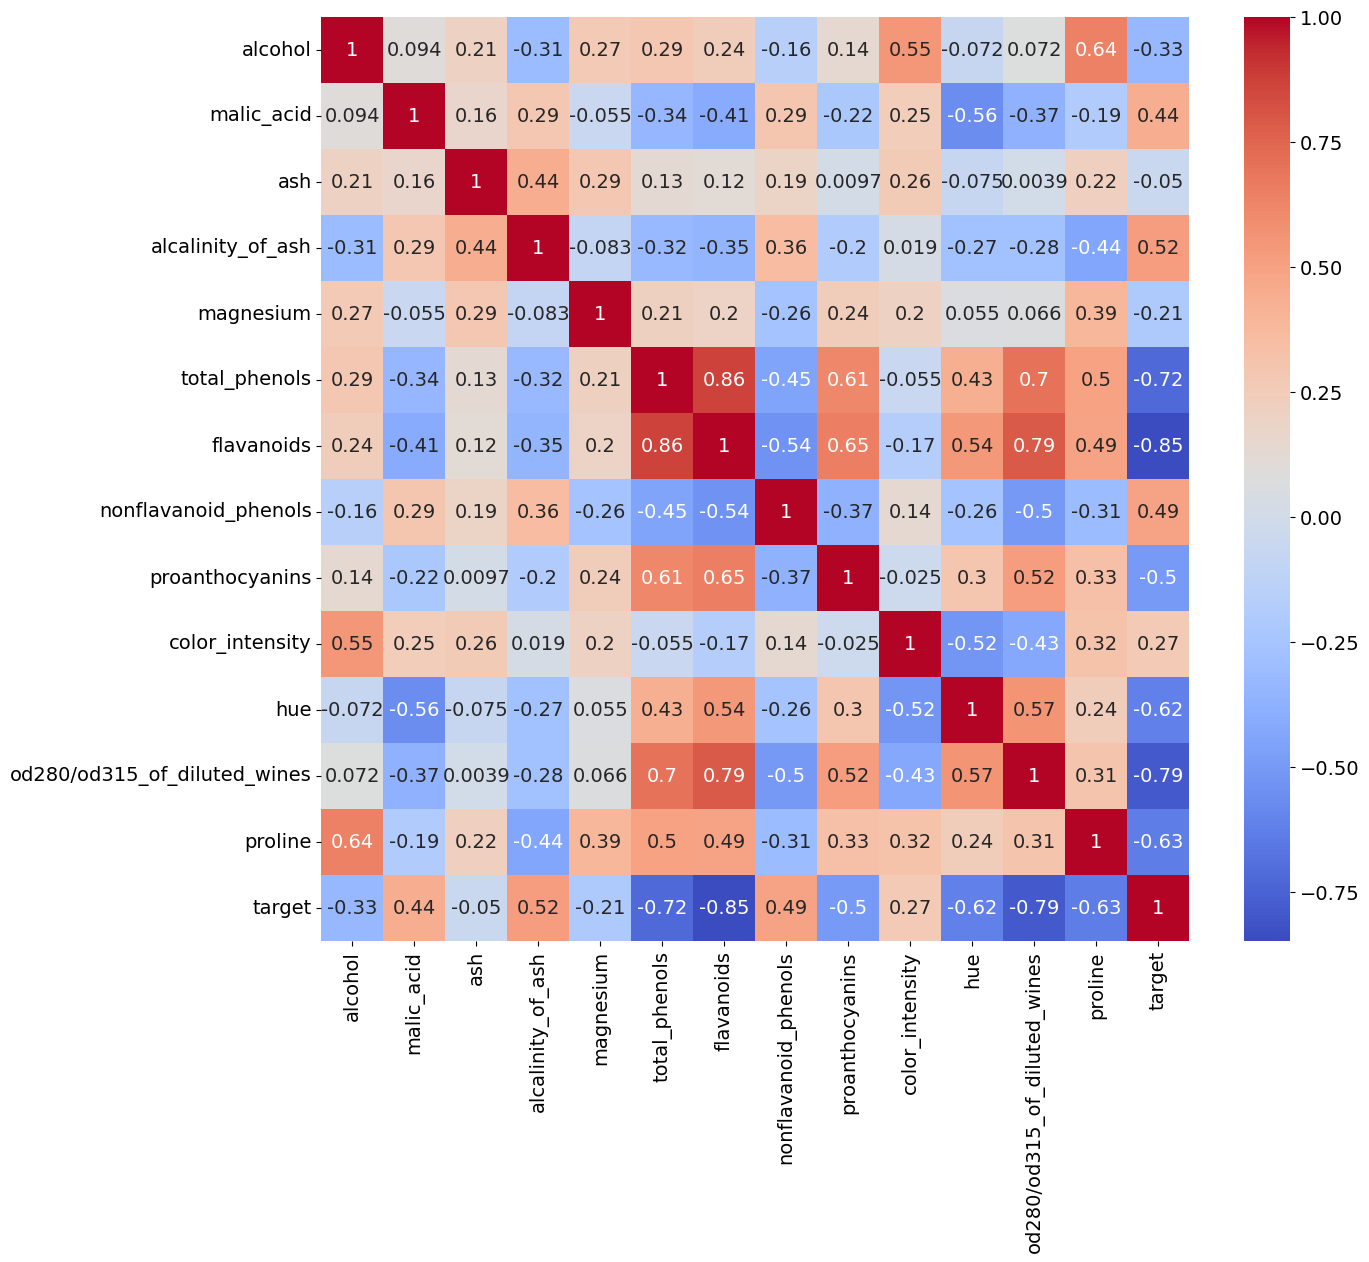

In [ ]:
corr = wdf.corr()
plt.subplots(figsize=(14,12))
sns.heatmap(corr , xticklabels=corr.columns, yticklabels=corr.columns,
            annot= True, cmap = 'coolwarm')

<Axes: xlabel='target', ylabel='count'>

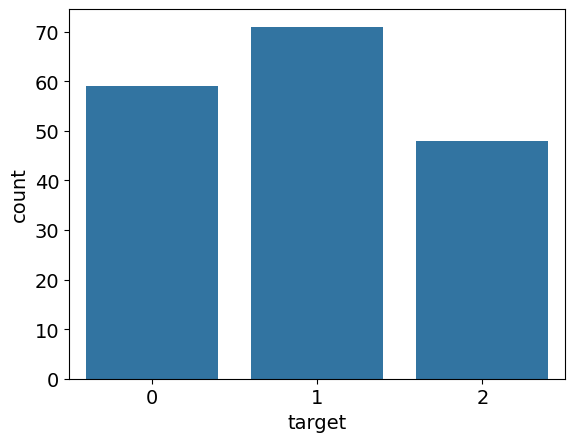

In [ ]:
sns.countplot(x='target' , data = wdf)

In [ ]:
wdf['target'].value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

<ipython-input-12-d7403c1ac19d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wdf.alcalinity_of_ash ,kde=1)


<Axes: xlabel='alcalinity_of_ash', ylabel='Density'>

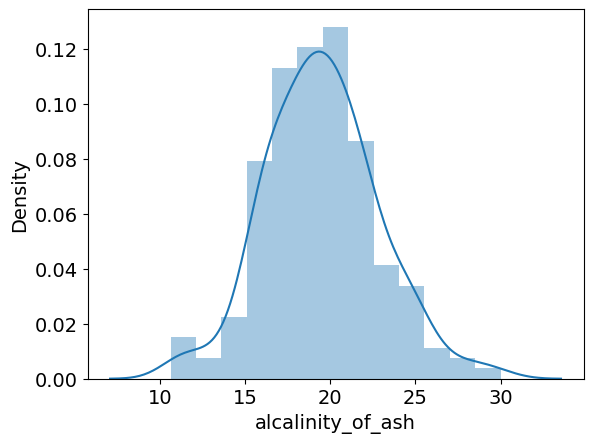

In [ ]:
sns.distplot(wdf.alcalinity_of_ash ,kde=1)

<ipython-input-13-12a2514026e8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wdf.alcohol,kde = 0)


<Axes: xlabel='alcohol'>

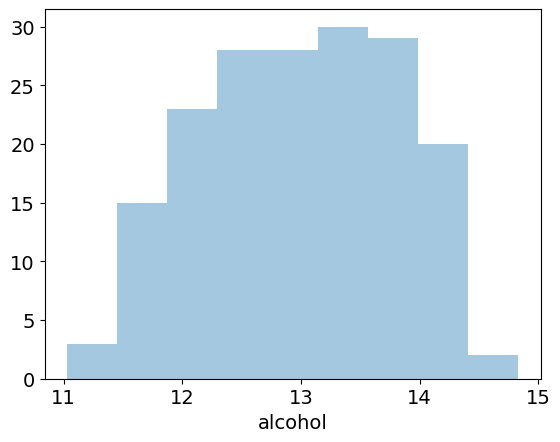

In [ ]:
sns.distplot(wdf.alcohol,kde = 0)

<Axes: xlabel='alcalinity_of_ash', ylabel='target'>

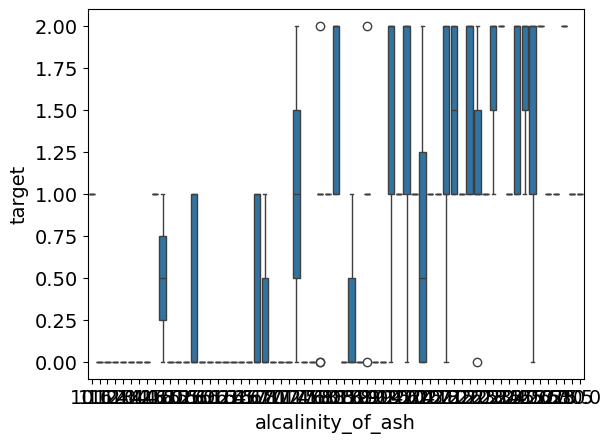

In [ ]:
sns.boxplot(x = 'alcalinity_of_ash',y = 'target',data = wdf)

In [ ]:
wdf['class'] = wdf['target'].map({0:'class 0',1:'class 1',2:'class 2'})

<Axes: xlabel='alcalinity_of_ash', ylabel='class'>

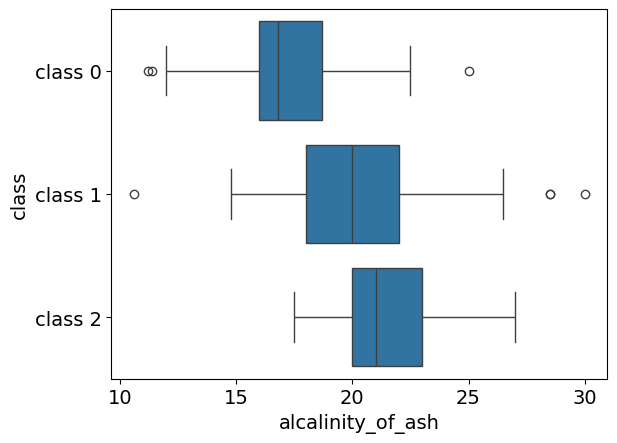

In [ ]:
sns.boxplot(x='alcalinity_of_ash',y='class',data=wdf)

<Axes: xlabel='alcohol', ylabel='class'>

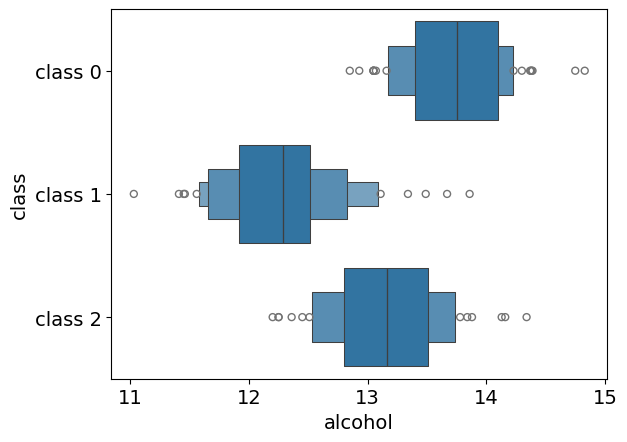

In [ ]:
sns.boxenplot(x = 'alcohol' , y = 'class' , data= wdf)

<Axes: xlabel='alcohol', ylabel='Density'>

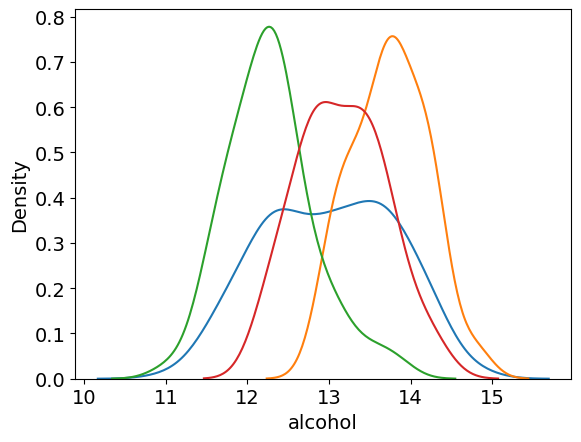

In [ ]:
sns.kdeplot(wdf['alcohol'],label='total dist')
sns.kdeplot(wdf['alcohol'][wdf.target==0],label='class 0')
sns.kdeplot(wdf['alcohol'][wdf.target==1],label='class 1')
sns.kdeplot(wdf['alcohol'][wdf.target==2],label='class 2')

# 第二個資料檔 Wine Quality

- [UCI: Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)
- [Predicting Wine Quality with Several Classification Techniques](https://towardsdatascience.com/predicting-wine-quality-with-several-classification-techniques-179038ea6434)
- [Wine Quality CSV (kaggle version)](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)
- [Step-by-step guide for predicting Wine Preferences using Scikit-Learn](https://medium.com/analytics-vidhya/step-by-step-guide-for-predicting-wine-quality-using-scikit-learn-de5869f8f91a)

## 下載 wine quality data

### from UCI repository

In [ ]:
wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

In [ ]:
fetch_file_via_requests(wine_url, data_dir)
wine_dbfile = os.path.join(data_dir,'winequality-red.csv')

### from shared google drive

In [ ]:
wine_dbfile = os.path.join(data_dir, 'wine.csv')
fetch_gdrive_file(RED_WINE,wine_dbfile)

Downloading...
From: https://drive.google.com/uc?id=1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk
To: /content/drive/My Drive/adventures/wine quality/wine.csv
100%|██████████| 101k/101k [00:00<00:00, 18.9MB/s]


- [Pandas DataFrame.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [ ]:
wine_dbfile = os.path.join(data_dir, 'winequality-red.csv')
df = pd.read_csv(wine_dbfile, sep=';')

In [ ]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


- fixed acidity 固定酸度
- volatile acidity 揮發性酸度
- citric acid 檸檬酸
- residual sugar 殘糖
- chlorides 氯化物
- free sulfur dioxide 游離二氧化硫
- total sulfur dioxide 總二氧化硫
- sulphates 硫酸鹽
- alcohol 酒精
- pH 酸鹼值
- density 密度

## Explore Dataset

In [ ]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
df.shape

(1599, 12)

### DataFrame Overview 整體資訊

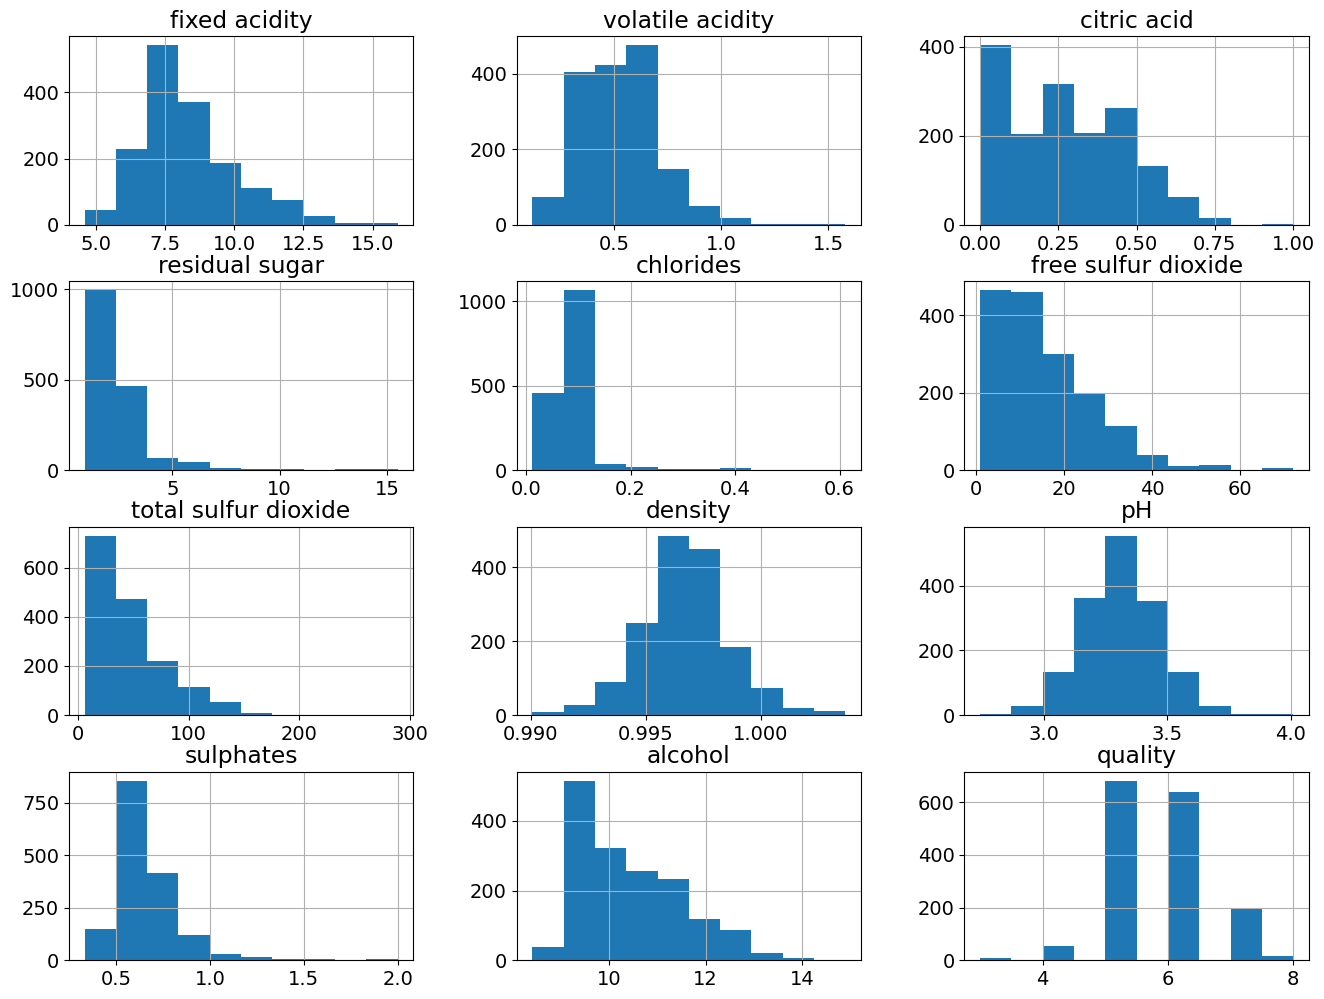

In [ ]:
df.hist(bins = 10 , figsize = (16,12))
plt.show()

<Axes: >

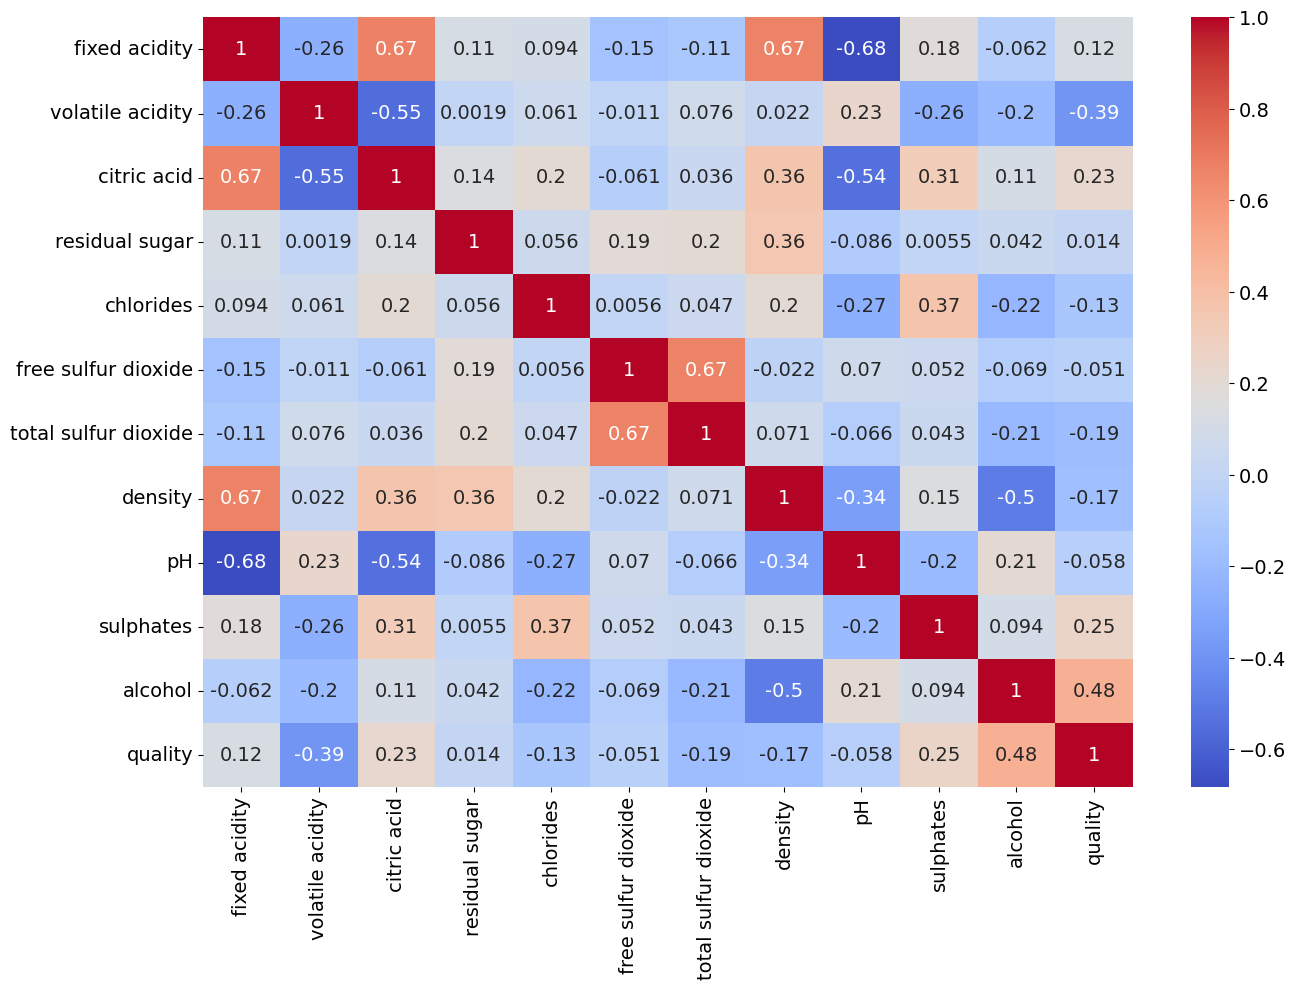

In [ ]:
fig ,ax = plt.subplots(figsize = (15,10))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot = True, cmap = 'coolwarm' , ax=ax)

### 特定欄位的相關資訊

In [ ]:
df['alcohol'].mean()

np.float64(10.422983114446529)

In [ ]:
df['alcohol'].value_counts()

,count
alcohol,
9.500000,139
9.400000,103
9.800000,78
9.200000,72
10.000000,67
...,...
9.950000,1
9.233333,1
9.250000,1


In [ ]:
len(df['alcohol'].unique())

65

<Axes: xlabel='alcohol'>

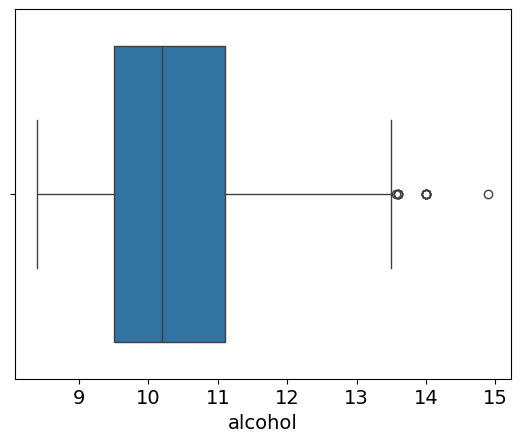

In [ ]:
sns.boxplot(x = 'alcohol',data = df)

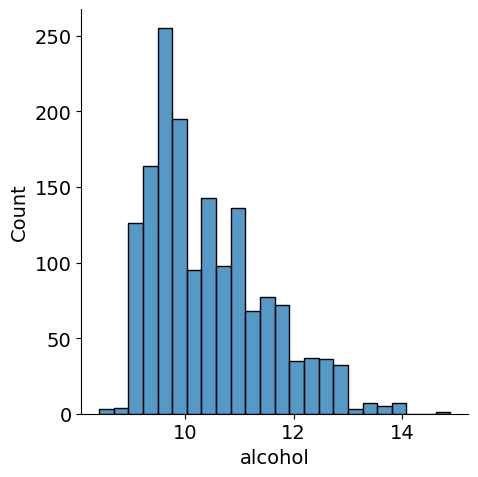

In [ ]:
sns.displot(df['alcohol'])

In [ ]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

<Axes: xlabel='quality', ylabel='count'>

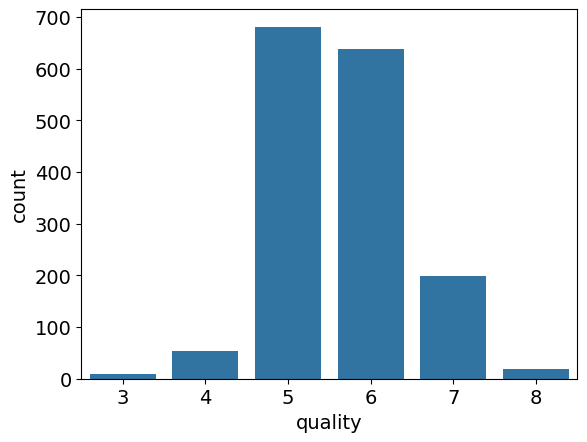

In [ ]:
sns.countplot(x='quality' , data = df)

In [ ]:
df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [ ]:
dfqu8=df.loc[df['quality']==8]

In [ ]:
dfqu8.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,8.566667,0.423333,0.391111,2.577778,0.068444,13.277778,33.444444,0.995212,3.267222,0.767778,12.094444,8.0
std,2.119656,0.144914,0.199526,1.295038,0.011678,11.155613,25.433240,0.002378,0.200640,0.115379,1.224011,0.0
min,5.000000,0.260000,0.030000,1.400000,0.044000,3.000000,12.000000,0.990800,2.880000,0.630000,9.800000,8.0
25%,7.250000,0.335000,0.302500,1.800000,0.062000,6.000000,16.000000,0.994175,3.162500,0.690000,11.325000,8.0
50%,8.250000,0.370000,0.420000,2.100000,0.070500,7.500000,21.500000,0.994940,3.230000,0.740000,12.150000,8.0
75%,10.225000,0.472500,0.530000,2.600000,0.075500,16.500000,43.000000,0.997200,3.350000,0.820000,12.875000,8.0
max,12.600000,0.850000,0.720000,6.400000,0.086000,42.000000,88.000000,0.998800,3.720000,1.100000,14.000000,8.0


### 兩個欄位之間的關係

In [ ]:
corr= df.corr()

In [ ]:
corr.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
corr['quality'].sort_values(ascending = False)[1:]

alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

<Axes: xlabel='quality', ylabel='volatile acidity'>

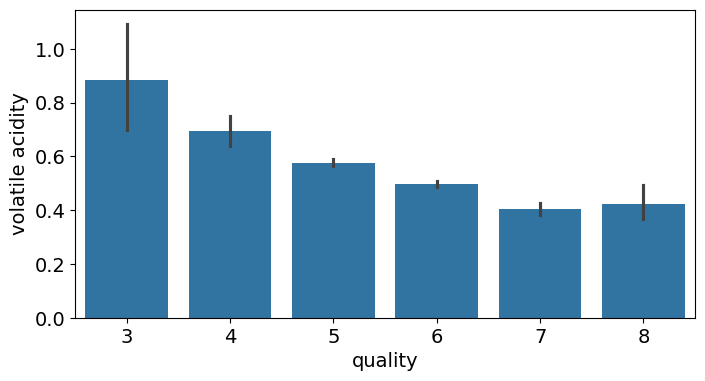

In [ ]:
fig = plt.figure(figsize= (8,4))
sns.barplot(x = 'quality',y = 'volatile acidity' , data = df)

<Axes: xlabel='quality', ylabel='residual sugar'>

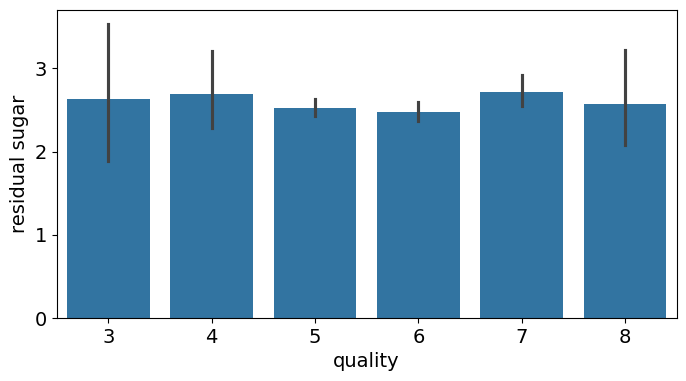

In [ ]:
fig = plt.figure(figsize= (8,4))
sns.barplot(x = 'quality',y = 'residual sugar' , data = df)

<Axes: xlabel='quality', ylabel='alcohol'>

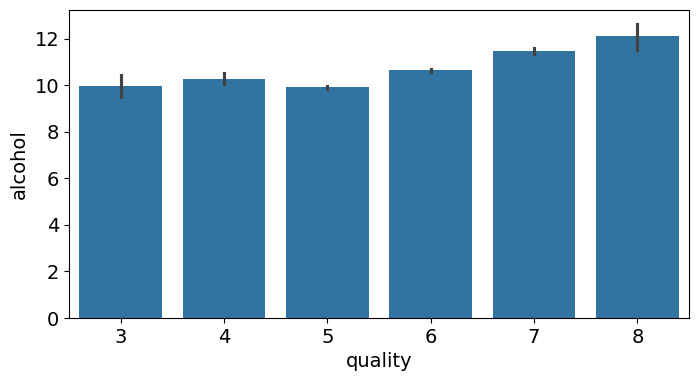

In [ ]:
fig = plt.figure(figsize= (8,4))
sns.barplot(x = 'quality',y = 'alcohol' , data = df)

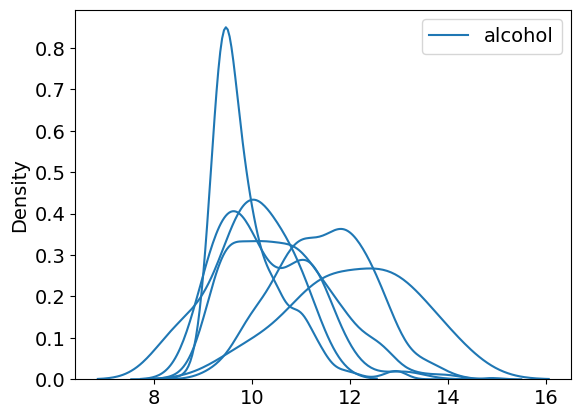

In [ ]:
#sns.kdeplot(df['alcohol'][df['quality']==8])
for i in np.sort(df['quality'].unique()):
    sns.kdeplot([df['alcohol'][df['quality']==i]] , \
        label = f'class={i:d}')

<ipython-input-48-91bffc23c66d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([df['alcohol'][df['quality']==3]] , \
<ipython-input-48-91bffc23c66d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([df['alcohol'][df['quality']==8]] , \


<Axes: ylabel='Density'>

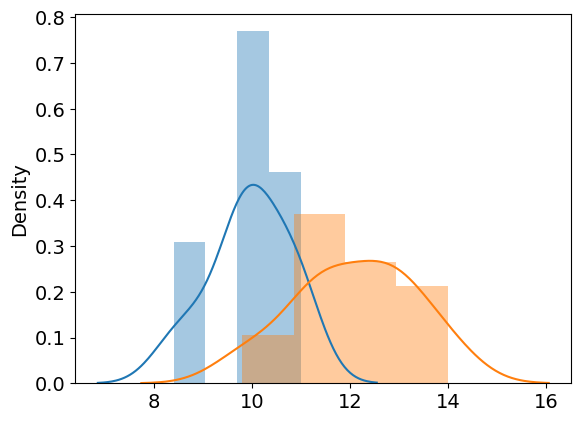

In [ ]:
#sns.distplot(df['alcohol'])
sns.distplot([df['alcohol'][df['quality']==3]] , \
        label = f'class={i:d}')
sns.distplot([df['alcohol'][df['quality']==8]] , \
        label = f'class={i:d}')

## Binay Classification

In [ ]:
y6 = df['quality'] >6
type(y) ,y6

(pandas.core.series.Series,
 0       False
 1       False
 2       False
 3       False
 4       False
         ...  
 1594    False
 1595    False
 1596    False
 1597    False
 1598    False
 Name: quality, Length: 1599, dtype: bool)

In [ ]:
y6 = pd.Categorical(y6)

<Axes: ylabel='count'>

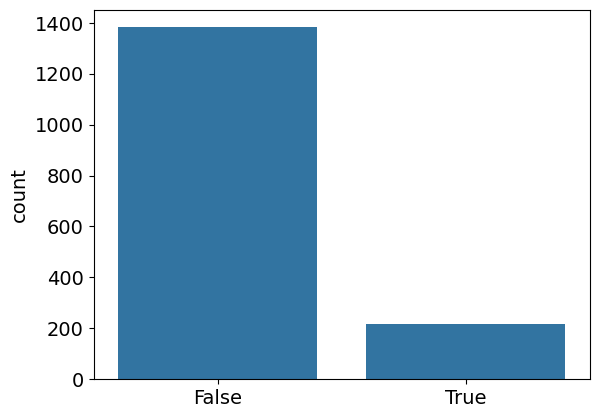

In [ ]:
sns.countplot(x=y6, orient="h")

<Axes: xlabel='count'>

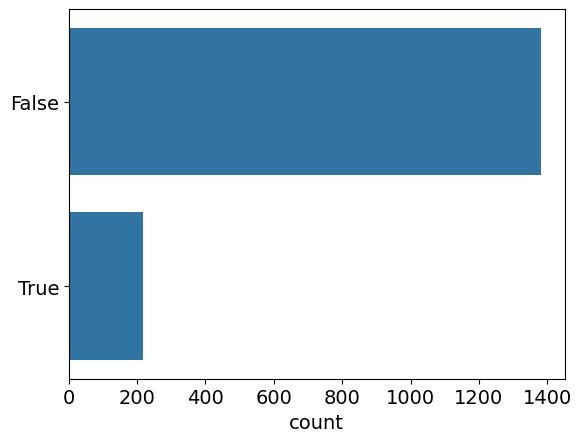

In [ ]:
sns.countplot(y6)

In [ ]:
bins = (2 , 6.5 ,8)
group_names = ['bad','good']
df['quality'] = pd.cut(df['quality'] , bins=bins , labels=group_names)

In [ ]:
df['quality']

0       bad
1       bad
2       bad
3       bad
4       bad
       ... 
1594    bad
1595    bad
1596    bad
1597    bad
1598    bad
Name: quality, Length: 1599, dtype: category
Categories (2, object): ['bad' < 'good']

In [ ]:
df['quality'].value_counts()

quality
bad     1382
good     217
Name: count, dtype: int64

### Select Classifier

In [ ]:
%%time
from sklearn.linear_model import SGDClassifier ,LogisticRegression
from sklearn.svm import SVC , LinearSVC
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_roc_curve , plot_confusion_matrix 已廢棄
#   可以使用sklearn.metric.RocCurveDisplay.from_predictions或者 sklearn.metric.RocCurveDisplay.from_estimator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import RocCurveDisplay

CPU times: user 73.7 ms, sys: 30 ms, total: 104 ms
Wall time: 276 ms


In [ ]:
x = df.drop(['quality'], axis = 1)
y = y6

x_train , x_test ,y_train , y_test = \
    train_test_split ( x,y , test_size = 0.25 , random_state = 42)



sc = MinMaxScaler()
#sc = StandarScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

clf = LinearSVC()
clf.fit(x_train,y_train)
y_hat = clf.predict(x_test)
rep = classification_report(y_test,y_hat)
print(rep)
print_now

              precision    recall  f1-score   support

       False       0.93      0.91      0.92       347
        True       0.48      0.55      0.51        53

    accuracy                           0.86       400
   macro avg       0.71      0.73      0.72       400
weighted avg       0.87      0.86      0.87       400



<function __main__.print_now()>

In [ ]:
from sklearn.metrics import RocCurveDisplay
#plot_roc_curve 在1.2 版本中已被删除。從1.2开始，改用RocCurveDisplay

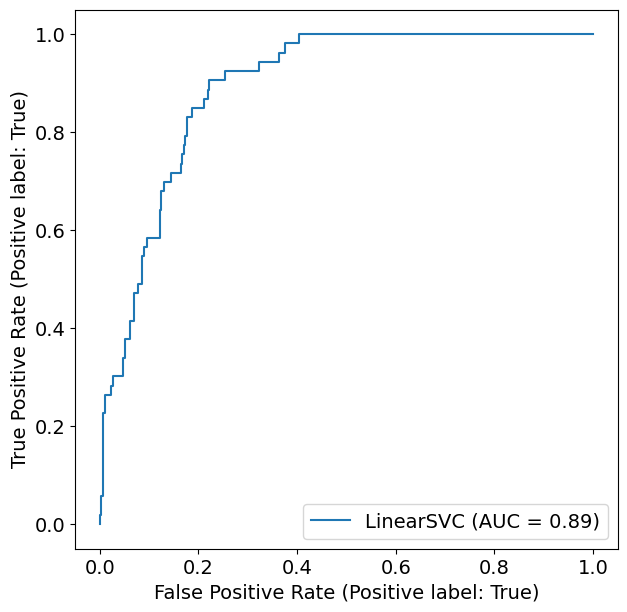

In [ ]:
fig , ax = plt.subplots (figsize=(7,7))
RocCurveDisplay.from_estimator(clf, x_test, y_test, ax=ax)

## Comparison of Algorithms

- [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
models = []
models.append(('LinearSVC', LinearSVC()))
models.append(('StochasticGD', SGDClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('KNeighbors', KNeighborsClassifier()))
# models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('LR Classifier', LogisticRegression()))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import KFold

sc= StandardScaler()
X = df.drop(['quality'],axis = 1 )
y = y6

x_train , x_test , y_train , y_test = \
    train_test_split(X,y,test_size = 0.25 , random_state=42)

x_train = sc.fit_transform (x_train)
x_test = sc.fit_transform(x_test)

results = []
names = []
scores = []
seed = 7
scoring = 'accuracy'

for name , model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model , x_train , y_train , \
                                 cv = kfold ,scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name:s} done , {cv_results.mean():f}')

print_now()

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

LinearSVC done , 0.879895
StochasticGD done , 0.863200
RandomForest done , 0.904895
DecisionTree done , 0.874895
GaussianNB done , 0.837332
KNeighbors done , 0.868214
LR Classifier done , 0.879895
2024-04-19 12:06:13.038060


In [ ]:
for i , r in enumerate(results):
    print(models[i][0])
    print('mean = %.4f std = %.4f' %(r.mean(), r.std()))

LinearSVC
mean = 0.8799 std = 0.0346
StochasticGD
mean = 0.8632 std = 0.0318
RandomForest
mean = 0.9049 std = 0.0281
DecisionTree
mean = 0.8749 std = 0.0300
GaussianNB
mean = 0.8373 std = 0.0352
KNeighbors
mean = 0.8682 std = 0.0373
LR Classifier
mean = 0.8799 std = 0.0332


Text(0.5, 1.0, 'Algorithm Comparison')

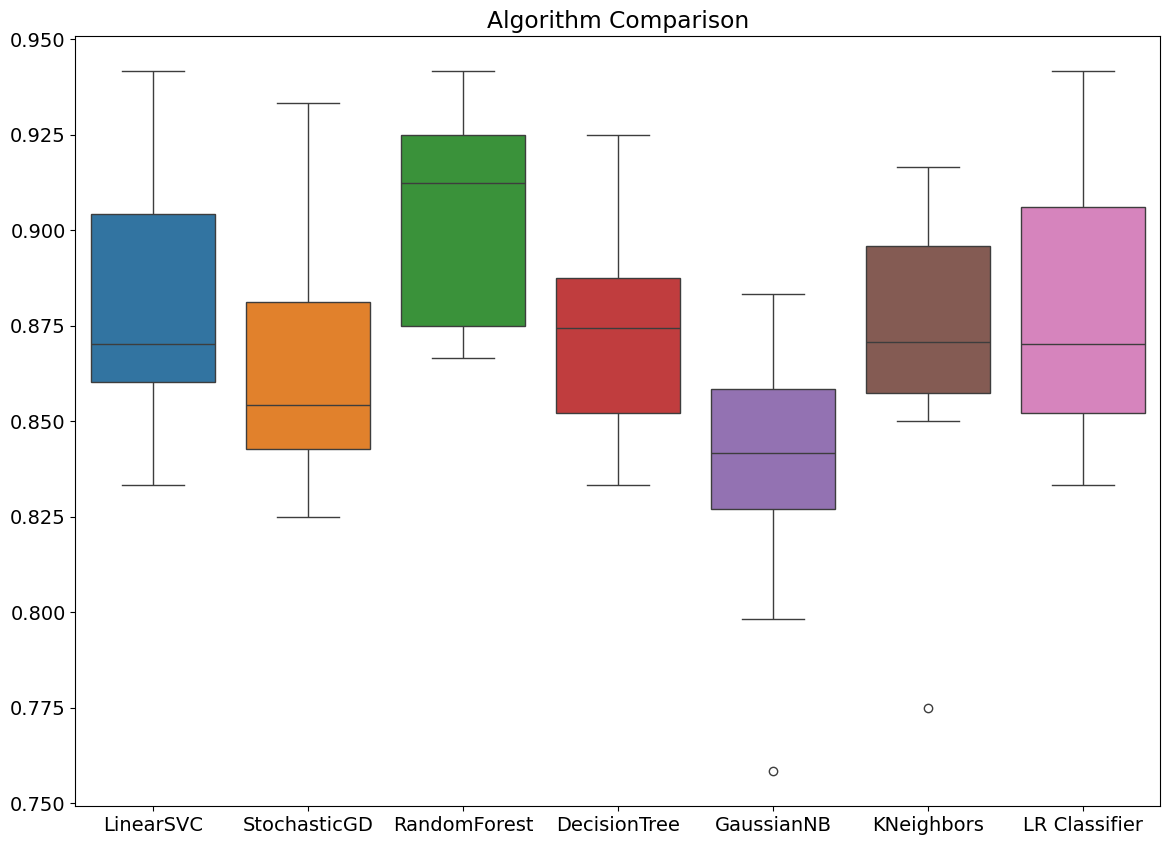

In [ ]:
adf = pd.DataFrame(data = results).transpose()
adf.columns = names
fig , ax  = plt.subplots(figsize = (14,10))
sns.boxplot(data = adf , ax = ax )
plt.title('Algorithm Comparison')

## Tuning Hyperparameters

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)
- [kNN API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier)

In [ ]:
x = df.drop(['quality'],axis = 1)
y = y6

x_train , x_test , y_train , y_test = \
    train_test_split(X,y,test_size = 0.25 , random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def knn_param_selection(X, y, nfolds):
    param = {
        'n_neighbors' : [1,3,5,7,9],
        'weights' : ['uniform','distance'],
        'algorithm' : ['ball_tree','kd_tree','brure']
    }
    grid_search = GridSearchCV(KNeighborsClassifier(),
            param_grid = param , scoring = 'accuracy' ,cv = nfolds )
    grid_search.fit(X, y)
    return grid_search.best_params_

print(knn_param_selection(x_train, y_train, 5))

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/skl

- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC)